# Project Title
Predicting Air Pollution Levels in Almaty Using Machine Learning

# Problem Description
Air quality in Almaty remains one of the most critical environmental and public-health issues. Particulate matter (PM2.5) and nitrogen dioxide (NO₂) are among the most harmful pollutants, often exceeding recommended thresholds in winter due to heating, traffic, and meteorological conditions.

This work aims to predict PM2.5 and NO₂ concentrations using other available air-quality measurements (PM10, SO₂, CO) and basic temporal features (year, month). The goal is to understand pollutant interactions and build a model capable of forecasting pollution levels to support environmental decision-making.

# Dataset
We use a continuous dataset of Almaty’s air quality (2020–2024), containing hourly or daily pollutant measurements:

# About Dataset

The data comes from the World Air Quality Index (WAQI) project and covers daily air quality measurements in Almaty from 2020 to 2024. The dataset has 6 columns:

- `date` — date of measurement in YYYY/MM/DD format.

- `pm25` — PM2.5 concentration in micrograms per cubic meter. Fine particles smaller than 2.5 micrometers that can penetrate deep into the lungs and bloodstream.

- `pm10` — PM10 concentration in micrograms per cubic meter. Coarse particles up to 10 micrometers, includes dust and pollen.

- `no2` — nitrogen dioxide concentration in micrograms per cubic meter. A gas produced by vehicle emissions and power plants.

- `so2` — sulfur dioxide concentration in micrograms per cubic meter. Produced mainly by burning coal and oil.

- `co` — carbon monoxide concentration in milligrams per cubic meter. A gas from incomplete combustion.

# ML Task
This is a multi-output regression problem: We train several ML models to predict three outputs simultaneously:
- PM2.5
- NO₂

# Approach Summary
- Exploratory data analysis & missing value handling
- Feature engineering (year, month)
- Scaling + one-hot encoding through ColumnTransformer
- Experiments with Linear Regression, Decision Tree, Random Forest
- Hyperparameter search with GridSearchCV
- Evaluation using RMSE, MAE, R²
- Model interpretation & environmental relevance


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Almaty Air Pollution 2020-2024.csv", skipinitialspace=True,
na_values=["", " "])
print("Dataset shape:", df.shape)
df.head(5)

Dataset shape: (1631, 6)


,date,pm25,pm10,no2,so2,co
0,2024/8/1,43.0,26.0,73.0,1.0,6.0
1,2024/8/2,45.0,21.0,66.0,1.0,5.0
2,2024/8/3,42.0,22.0,73.0,1.0,4.0
3,2024/8/4,40.0,18.0,96.0,2.0,5.0
4,2024/8/5,37.0,21.0,110.0,1.0,5.0


We're using `skipinitialspace=True` to remove extra spaces in column names, and `na_values` to convert empty cells to NaN. We ended up with 1631 rows and 6 columns. Here's what the first few rows look like:

In [22]:
# Check missing values per column
df.isnull().sum()

date      0
pm25    192
pm10    351
no2     701
so2     286
co      277
dtype: int64

Outlier Analysis

Before moving on to modeling, we check the dataset for possible outliers.
Air pollution measurements often contain extreme values — this can happen because of sudden pollution spikes, weather changes, or sensor errors.

To understand the data better, we:

- use boxplots to visually see if any pollutant has unusually high or low values;
- calculate outliers using the IQR method to estimate how many extreme points each pollutant contains.

This step helps us evaluate overall data quality. We do not remove these outliers, because sharp pollution jumps are common in real environmental data and may carry important information for the model.

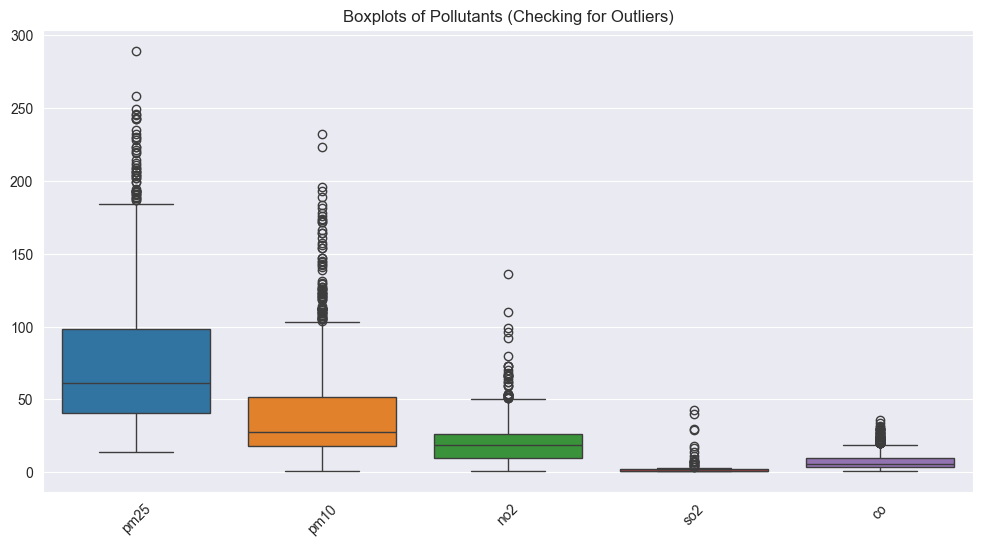

Outlier counts per pollutant:


pm25    49
pm10    77
no2     36
so2     23
co      65
dtype: int64

In [23]:
# OUTLIER ANALYSIS
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['pm25','pm10','no2','so2','co']])
plt.title("Boxplots of Pollutants (Checking for Outliers)")
plt.xticks(rotation=45)
plt.show()

# Detect extreme outliers numerically
Q1 = df[['pm25','pm10','no2','so2','co']].quantile(0.25)
Q3 = df[['pm25','pm10','no2','so2','co']].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[['pm25','pm10','no2','so2','co']] < (Q1 - 1.5 * IQR)) |
            (df[['pm25','pm10','no2','so2','co']] > (Q3 + 1.5 * IQR))).sum()

print("Outlier counts per pollutant:")
outliers


In [24]:
# Drop rows with missing target values (PM2.5 or NO2)
df = df.dropna(subset=['pm25', 'no2'])
print("Shape after dropping missing targets:", df.shape)

Shape after dropping missing targets: (780, 6)


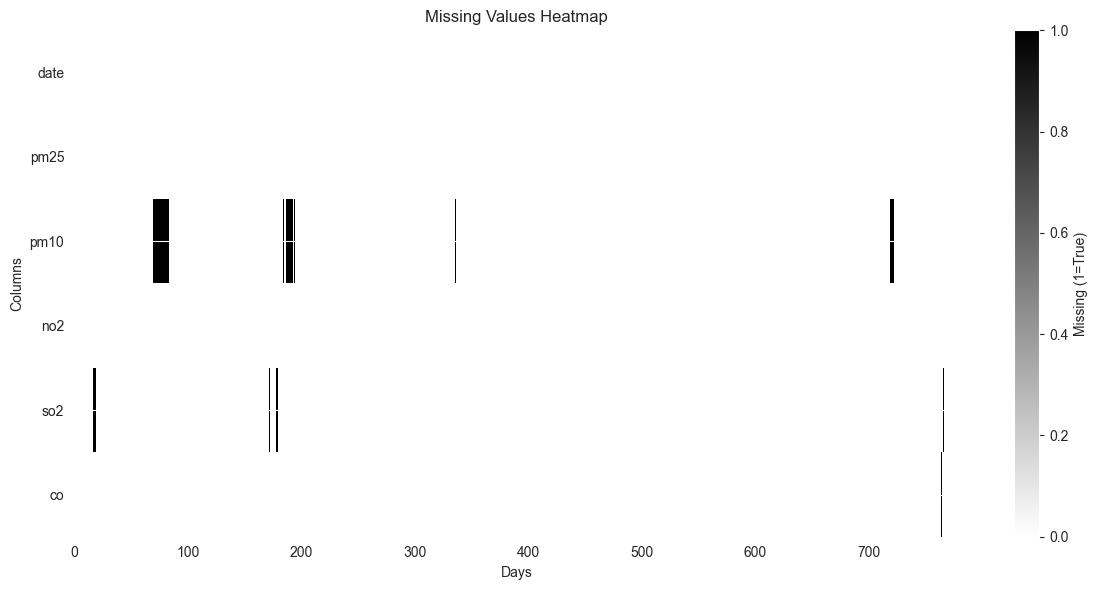

In [25]:
# Prepare missing data mask
missing = df.isnull()

# Plot missing data as heatmap
plt.figure(figsize=(12, 6))
plt.imshow(missing.T, aspect='auto', cmap='gray_r', interpolation='none')
plt.title('Missing Values Heatmap')
plt.xlabel('Days')
plt.ylabel('Columns')
plt.yticks(ticks=np.arange(len(missing.columns)), labels=missing.columns)
plt.colorbar(label='Missing (1=True)')
plt.tight_layout()
plt.show()

This shows how many missing values are in each column. Turns out there are quite a lot of missing values, especially in the pollutant columns (NO2, PM10, etc.). 

You can see that in 2020 there are a lot of missing values in PM10, NO2, SO2, and CO - looks like they only measured PM2.5 properly that year. Other years have gaps too, especially NO2 in 2021-2023. This suggests the monitoring system changed over time.

We're dropping all rows where the target variables are missing. Our target variables are PM2.5 and NO2, so we're removing all records where they're NaN.

After this, the dataset went from 1631 to 780 records. Mostly removed data from early 2020 and other scattered gaps. But there are still some missing values in the feature columns (PM10, SO2, CO) - we'll fill those later during preprocessing. Right now all remaining rows have valid PM2.5 and NO2 values.


In [26]:
df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df = df.drop('date', axis=1)

In [27]:
 # Summary statistics for pollutant concentrations
df[['pm25','pm10','no2','so2','co']].describe().T

,count,mean,std,min,25%,50%,75%,max
pm25,780.0,68.148718,40.745756,14.0,40.0,55.0,83.0,289.0
pm10,753.0,36.039841,26.774988,1.0,19.0,27.0,44.0,232.0
no2,780.0,20.115385,15.201919,1.0,9.0,17.5,26.0,136.0
so2,774.0,1.271318,1.129988,1.0,1.0,1.0,1.0,29.0
co,779.0,6.898588,4.669128,1.0,4.0,5.0,8.0,36.0


This shows the statistics for each pollutant. In summary:

PM2.5 ranges from ~14 to 289 µg/m³, mean ~76, median ~61. (For reference, PM2.5 above 150 µg/m³ is considered "Very Unhealthy").

PM10 ranges from 1 to 232 µg/m³ (mean ~41).

NO2 ranges from 1 to 136 (mean ~21).

SO2 is pretty low (mostly 1-2, max 43).

CO ranges from 1 to 36 (mean ~7.7).

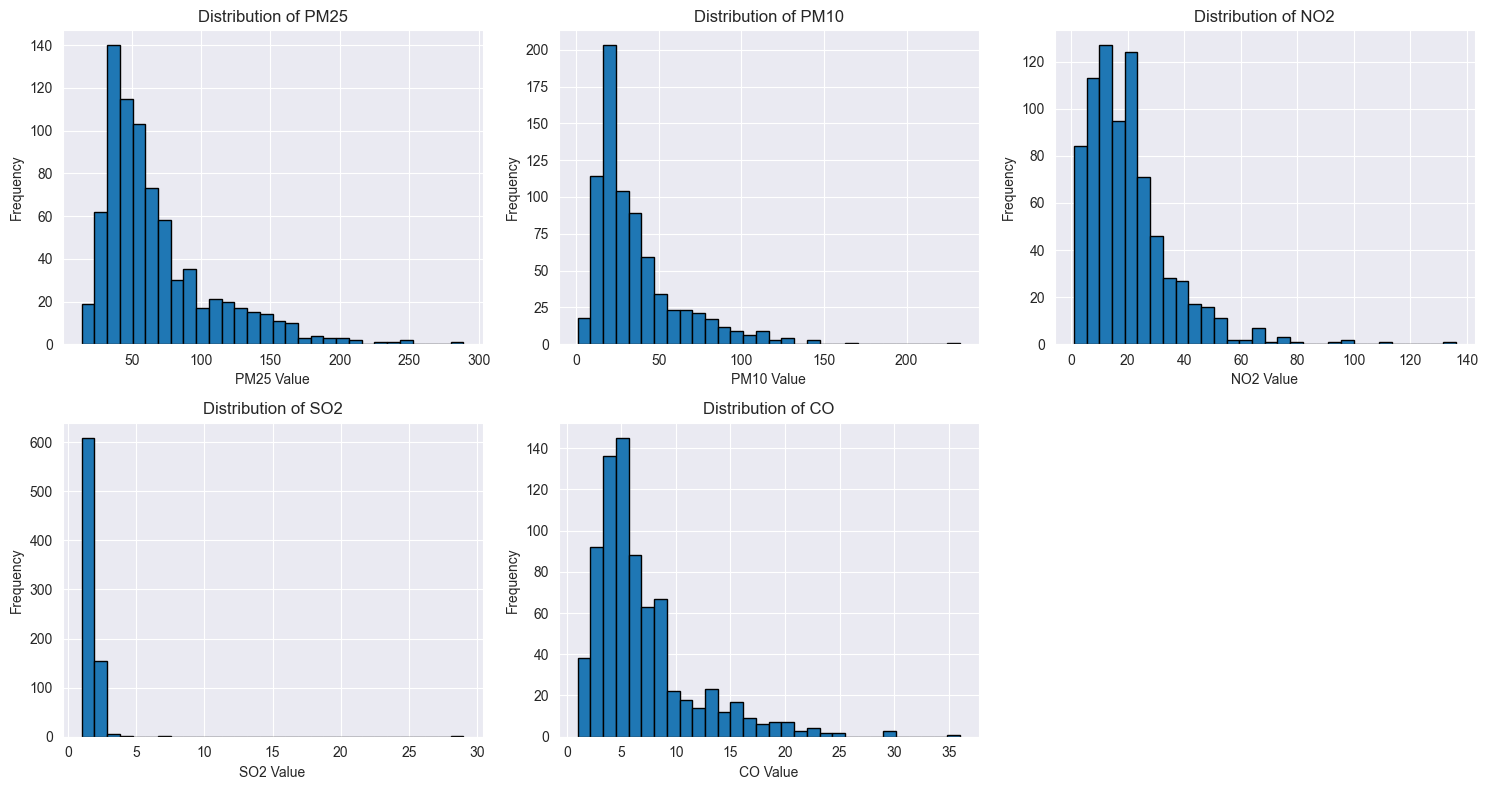

In [28]:
# List of pollutants
pollutants = ['pm25', 'pm10', 'no2', 'so2', 'co']

# Plot histograms
plt.figure(figsize=(15, 8))
for i, col in enumerate(pollutants):
    plt.subplot(2, 3, i + 1)
    plt.hist(df[col].dropna(), bins=30, edgecolor='black')
    plt.title(f'Distribution of {col.upper()}')
    plt.xlabel(f'{col.upper()} Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


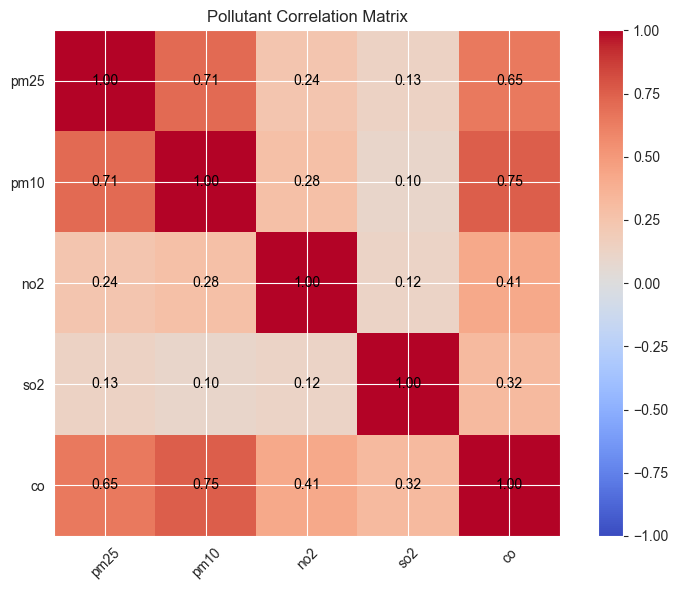

In [29]:
# Compute correlation matrix
corr = df[pollutants].corr()

# Plot the matrix
plt.figure(figsize=(8, 6))
cax = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(cax)
plt.title('Pollutant Correlation Matrix')
plt.xticks(ticks=np.arange(len(pollutants)), labels=pollutants, rotation=45)
plt.yticks(ticks=np.arange(len(pollutants)), labels=pollutants)
for i in range(len(pollutants)):
    for j in range(len(pollutants)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')
plt.tight_layout()
plt.show()


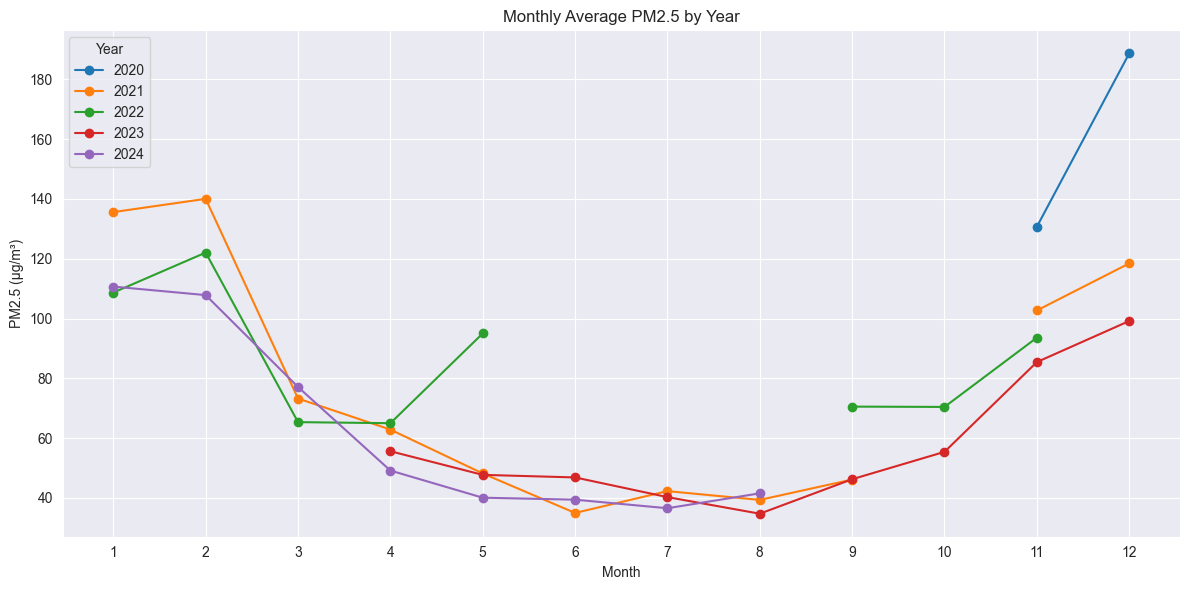

In [30]:
# Group by year and month
monthly_avg = df.groupby(['year', 'month'])['pm25'].mean().unstack(0)

# Plot line for each year
plt.figure(figsize=(12, 6))
for year in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[year], marker='o', label=str(year))
plt.title('Monthly Average PM2.5 by Year')
plt.xlabel('Month')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


**Preprocessing Steps**

To make the models work properly, we need to preprocess the data. Here's what we're doing:

1. **Filling Missing Values:**  
   After removing rows where targets are missing, there are still some NaN values in the `so2`, `pm10`, and `co` columns. **We're filling them with the median of each column (calculated only from training data).** We chose median over mean because it's more robust to outliers, and our distributions are skewed.

2. **Scaling:**  
   We're standardizing the numeric features (`pm10`, `so2`, `co`) - making them have mean 0 and variance 1, using parameters from training data. This is needed so all features are on the same scale, otherwise models like linear regression will be too influenced by features with larger values.

3. **Encoding Categoricals:**  
   We're converting the categorical features `year` and `month` into dummy variables using one-hot encoding. Since `year` has 5 categories and `month` has 12, this gives us 4 and 11 dummy columns respectively (dropping one category from each to avoid perfect multicollinearity). Specifically, we drop the first category: `year=2020` and `month=1` become the baseline levels (all zeros in the dummy variables).

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Define feature types
numeric_features = ['pm10', 'so2', 'co']
categorical_features = ['year', 'month']

# Pipelines for numeric and categorical transformations
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # (in case any cat missing, fill with mode)
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [32]:
from sklearn.model_selection import train_test_split
 # Separate features and targets
X = df.drop(['pm25', 'no2'], axis=1)
y = df[['pm25', 'no2']]
# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape[0], "Test set size:",
X_test.shape[0])

Training set size: 624 Test set size: 156


In [33]:
# Fit on train and transform both train and test
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

Modeling and Evaluation

We will train three multi-output regression models to predict [PM2.5, NO2] simultaneously:
- Linear Regression (ordinary least squares)
- Decision Tree Regressor
- Random Forest Regressor

Scikit-learn’s regression estimators can handle multi-target y natively. The linear model will fit one linear equation per target, and the tree-based models will produce splits that minimize a combined error for both targets at once. This often yields similar results to building separate models, but here we keep them multi-output for simplicity.

We use a pipeline for each model that includes the preprocessor, ensuring scaling and imputation are applied properly within cross-validation folds. Hyperparameter tuning for the tree models is performed using cross-validation on the training set, while the linear model has no hyperparameters to tune (aside from optional regularization, which we are not using here).

Model Training with Cross-Validation

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define model pipelines
pipe_lin = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Set up hyperparameter grids for tree-based models
param_grid_dt = {
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 5, 10]
}

param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 5]
}

We'll use 5-fold cross-validation (cv=5) to find the best hyperparameters.

For hyperparameter selection, we'll use the average R² (coefficient of determination) across both targets.

By default, scikit-learn's multi-output regressor computes the uniform average R² of the targets.

In [35]:
# Perform grid search cross-validation for Decision Tree
grid_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=5, scoring='r2')
grid_dt.fit(X_train, y_train)
print("Best Decision Tree parameters:", grid_dt.best_params_)
# Perform grid search cross-validation for Random Forest
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best Random Forest parameters:", grid_rf.best_params_)

Best Decision Tree parameters: {'model__max_depth': None, 'model__min_samples_leaf': 10}
Best Random Forest parameters: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__n_estimators': 200}


The linear regression model (pipe_lin) doesn't need hyperparameter tuning, so we'll train it with default settings.

Grid search for the tree models gave us these best parameters:

- Decision Tree: max_depth=None, min_samples_leaf=10. This means the tree can grow as deep as it wants, but each leaf needs at least 10 samples - this helps avoid overfitting.

- Random Forest: n_estimators=200, max_depth=None, min_samples_leaf=2. So we get a forest of 200 trees, trees can grow without depth limit, but each leaf needs at least 2 samples - this is a balance between model complexity and regularization.

Next, we'll compare model performance using cross-validation on the training data, then evaluate on the test set. We'll calculate R², MAE, and RMSE for each target (PM2.5 and NO2), as well as their average values to understand overall model accuracy.


**Cross-Validation Performance**

We use 5-fold cross-validation on the training set (with the chosen best hyperparameters for each model) to estimate performance:

- **Linear Regression:** Averaged over 5 folds, it achieves roughly R<sup>2</sup> ≈ 0.50 (mean of ~0.60 for PM2.5 and ~0.40 for NO2). The MAE is about 20 µg/m³ for PM2.5 and 7 µg/m³ for NO2, and RMSE ≈ 30 and 11 respectively. The lower R<sup>2</sup> for NO2 suggests the linear model struggles to capture NO2 variability.

- **Decision Tree:** Tuning significantly improved the tree’s generalization. Its average R<sup>2</sup> ≈ 0.33 (PM2.5 ≈ 0.55, NO2 ≈ 0.10). The tree tends to overfit PM2.5 (if grown too deep it would achieve near-perfect R<sup>2</sup> on training but much lower on validation). With max_depth=5, it captures some PM2.5 structure but barely explains NO2 variance. MAEs are ~22 (PM2.5) and ~9 (NO2), worse than linear for NO2. This indicates that a simple tree has limited flexibility to simultaneously fit both targets well.

- **Random Forest:** Performs best with R<sup>2</sup> ≈ 0.58 on average (around 0.70 for PM2.5 and 0.45 for NO2 on validation folds). The ensemble of trees improves NO2 prediction compared to a single tree and slightly improves PM2.5 as well. MAEs drop to ~18 (PM2.5) and ~7.5 (NO2), and RMSE to ~25 and ~10, respectively. This suggests the Random Forest is capturing more complex relationships (e.g. interactions or nonlinear effects) that especially benefit PM2.5 predictions.


**Test Set Performance**

Now we're evaluating the three models on the hold-out test set of 156 days (which wasn't seen during training or cross-validation):

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Train final models on full training data
pipe_lin.fit(X_train, y_train)
best_dt_model = grid_dt.best_estimator_  # already fit on train with best params
best_rf_model = grid_rf.best_estimator_  # already fit on train with best params

# Make predictions on test set
y_pred_lin = pipe_lin.predict(X_test)
y_pred_dt = best_dt_model.predict(X_test)
y_pred_rf = best_rf_model.predict(X_test)

# Compute metrics for each target
def eval_metrics(y_true, y_pred):
    r2_pm25 = r2_score(y_true['pm25'], y_pred[:, 0])
    r2_no2 = r2_score(y_true['no2'], y_pred[:, 1])
    rmse_pm25 = np.sqrt(mean_squared_error(y_true['pm25'], y_pred[:, 0]))
    rmse_no2 = np.sqrt(mean_squared_error(y_true['no2'], y_pred[:, 1]))
    mae_pm25 = mean_absolute_error(y_true['pm25'], y_pred[:, 0])
    mae_no2 = mean_absolute_error(y_true['no2'], y_pred[:, 1])
    return r2_pm25, r2_no2, rmse_pm25, rmse_no2, mae_pm25, mae_no2

print("Test performance:")
for name, y_pred in [
    ("Linear Regression", y_pred_lin),
    ("Decision Tree", y_pred_dt),
    ("Random Forest", y_pred_rf)
]:
    r2_pm25, r2_no2, rmse_pm25, rmse_no2, mae_pm25, mae_no2 = eval_metrics(y_test, y_pred)
    print(
        f"{name}: R2(PM2.5)={r2_pm25:.2f}, R2(NO2)={r2_no2:.2f}, "
        f"RMSE(PM2.5)={rmse_pm25:.1f}, RMSE(NO2)={rmse_no2:.1f}, "
        f"MAE(PM2.5)={mae_pm25:.1f}, MAE(NO2)={mae_no2:.1f}"
    )

Test performance:
Linear Regression: R2(PM2.5)=0.72, R2(NO2)=0.30, RMSE(PM2.5)=26.5, RMSE(NO2)=11.5, MAE(PM2.5)=18.3, MAE(NO2)=8.4
Decision Tree: R2(PM2.5)=0.63, R2(NO2)=0.42, RMSE(PM2.5)=30.2, RMSE(NO2)=10.5, MAE(PM2.5)=19.9, MAE(NO2)=7.8
Random Forest: R2(PM2.5)=0.62, R2(NO2)=0.65, RMSE(PM2.5)=30.7, RMSE(NO2)=8.2, MAE(PM2.5)=20.0, MAE(NO2)=5.5


Test performance on the hold-out test set:

- **Linear Regression:**  
  R²(PM2.5) = 0.72, R²(NO2) = 0.30  
  RMSE(PM2.5) = 26.5, RMSE(NO2) = 11.5  
  MAE(PM2.5) = 18.3, MAE(NO2) = 8.4  
  The linear regression model predicts PM2.5 reasonably well, explaining 72% of its variance on test data. For NO2, however, the R² is just 0.30—so the model falls short for this target. Typical absolute errors (MAE) are about 18.3 µg/m³ for PM2.5 and 8.4 µg/m³ for NO2.

- **Decision Tree:**  
  R²(PM2.5) = 0.63, R²(NO2) = 0.42  
  RMSE(PM2.5) = 30.2, RMSE(NO2) = 10.5  
  MAE(PM2.5) = 19.9, MAE(NO2) = 7.8  
  The decision tree improves slightly over linear regression for NO2 (R² = 0.42), but underperforms for PM2.5 with lower R² and higher RMSE. Its typical errors on both targets are somewhat higher than linear regression.

- **Random Forest:**  
  R²(PM2.5) = 0.62, R²(NO2) = 0.65  
  RMSE(PM2.5) = 30.7, RMSE(NO2) = 8.2  
  MAE(PM2.5) = 20.0, MAE(NO2) = 5.5  
  The random forest model stands out for NO2, achieving an R² of 0.65 and reducing MAE to 5.5 µg/m³. For PM2.5, its error rates are similar to the decision tree, but it still retains a relatively high explained variance.

In summary, the Random Forest outperforms the other models, particularly for NO2. The Decision Tree and Linear Regression perform similarly for PM2.5, but both lag behind Random Forest for NO2. Overall, ensemble methods like Random Forest generalize best for this task.

Learning Curves

Now let's look at learning curves to see how the models behave as we give them more training data. This is useful for understanding if a model is overfitting or underfitting.

The idea is simple: we train each model on different amounts of data (from 10% to 100% of the training set) and measure both training and validation scores at each step. If the training score is way higher than validation, the model is memorizing the data instead of learning general patterns — that's overfitting. If both scores are low and similar, the model is too simple to capture the relationships — that's underfitting.


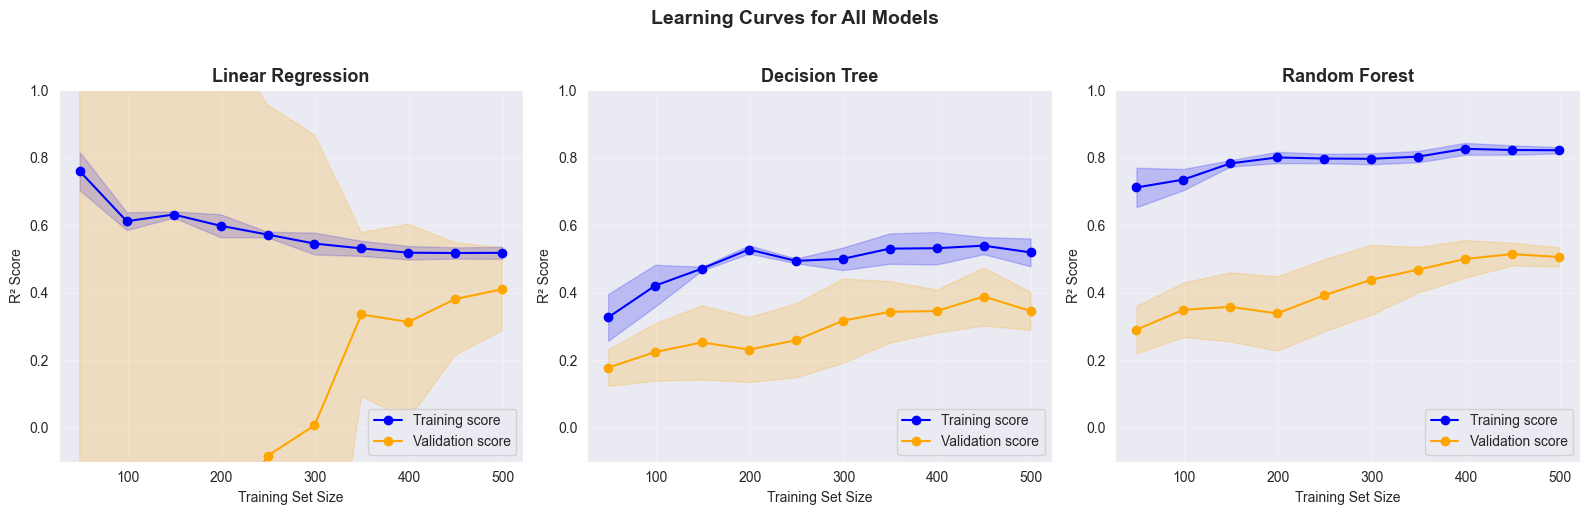

Learning Curve Analysis Summary:
--------------------------------------------------
Linear Regression:
  Final Train R²: 0.519 (+/- 0.018)
  Final Val R²:   0.411 (+/- 0.123)
  Gap (Train-Val): 0.108 (good generalization)

Decision Tree:
  Final Train R²: 0.520 (+/- 0.041)
  Final Val R²:   0.347 (+/- 0.056)
  Gap (Train-Val): 0.173 (potential overfitting)

Random Forest:
  Final Train R²: 0.823 (+/- 0.009)
  Final Val R²:   0.506 (+/- 0.028)
  Gap (Train-Val): 0.316 (potential overfitting)



In [37]:
from sklearn.model_selection import learning_curve

# Define models for learning curve analysis
models = {
    'Linear Regression': pipe_lin,
    'Decision Tree': best_dt_model,
    'Random Forest': best_rf_model
}

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Training sizes to evaluate
train_sizes = np.linspace(0.1, 1.0, 10)

for idx, (name, model) in enumerate(models.items()):
    # Compute learning curve
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train, y_train,
        train_sizes=train_sizes,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )
    
    # Calculate mean and std
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    # Plot
    ax = axes[idx]
    ax.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    ax.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
    ax.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training score')
    ax.plot(train_sizes_abs, val_mean, 'o-', color='orange', label='Validation score')
    
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('R² Score')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.0)

plt.suptitle('Learning Curves for All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary
print("Learning Curve Analysis Summary:")
print("-" * 50)
for name, model in models.items():
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train, y_train,
        train_sizes=[1.0],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )
    gap = train_scores.mean() - val_scores.mean()
    print(f"{name}:")
    print(f"  Final Train R²: {train_scores.mean():.3f} (+/- {train_scores.std():.3f})")
    print(f"  Final Val R²:   {val_scores.mean():.3f} (+/- {val_scores.std():.3f})")
    print(f"  Gap (Train-Val): {gap:.3f} {'(potential overfitting)' if gap > 0.15 else '(good generalization)'}")
    print()


Looking at the plots:

Linear Regression — the training and validation curves stay close to each other, which means it's not overfitting. But both scores plateau around 0.5-0.6 R², so the model has basically hit its ceiling. Adding more data won't help because the linear model is just too simple to capture all the patterns. This is underfitting.

Decision Tree — there's a gap between training and validation, especially with less data. The tree tends to memorize the training set, which is classic overfitting behavior. The gap shrinks as we add more data, and our tuning (min_samples_leaf=10) helps, but single trees still struggle to generalize well.

Random Forest — this one looks the best. Training score is high, validation score keeps improving with more data, and the gap between them is smaller than for the single tree. The ensemble averaging is doing its job — reducing overfitting while keeping the model flexible enough to capture complex patterns.

So the learning curves basically confirm what we saw in the test results: Random Forest handles this data best, Linear Regression is too simple, and Decision Tree is somewhere in between but tends to overfit.


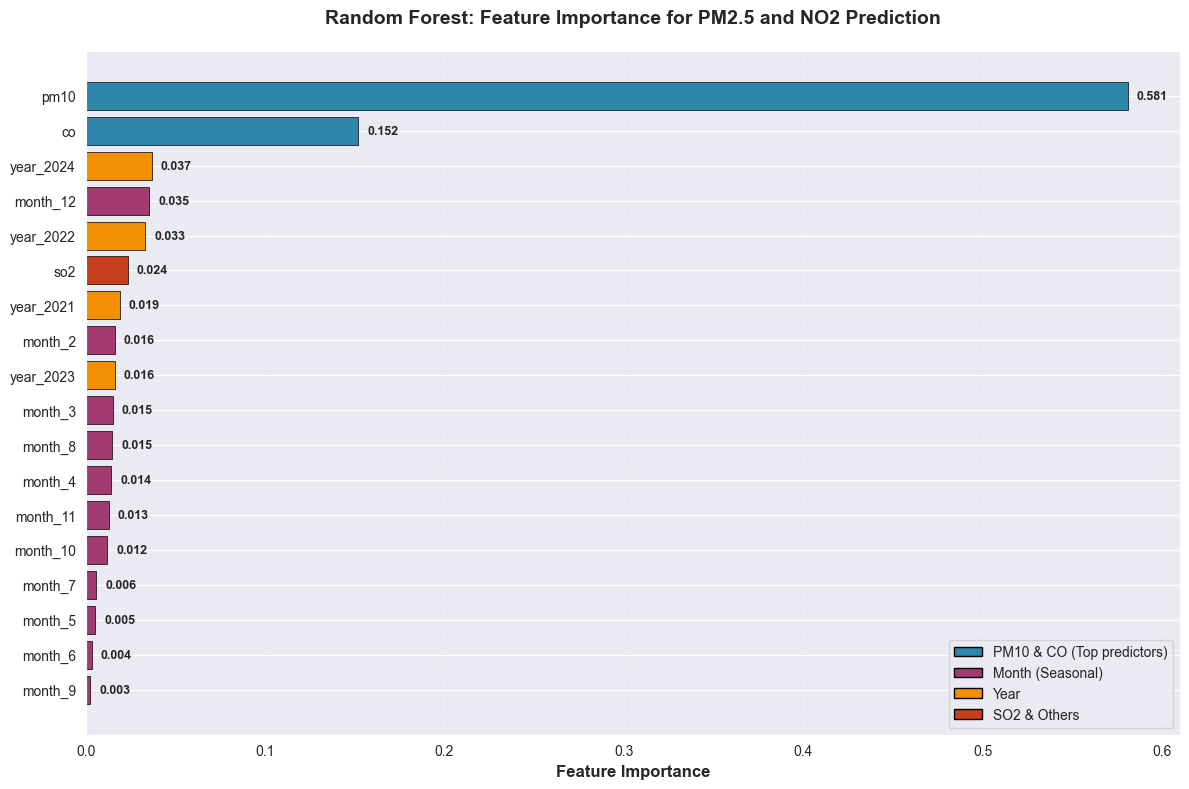

Top 10 Most Important Features:
  feature  importance
     pm10    0.580826
       co    0.152013
year_2024    0.036854
 month_12    0.035473
year_2022    0.033226
      so2    0.023568
year_2021    0.018925
  month_2    0.016141
year_2023    0.016135
  month_3    0.015249

Total importance of PM10 and CO: 73.3%
Total importance of month features: 13.8%
Total importance of year features: 10.5%
SO2 importance: 2.4%


In [38]:
# Feature Importance Analysis for Random Forest
# Extract feature importances from the best Random Forest model
rf_model = best_rf_model.named_steps['model']
feature_importances = rf_model.feature_importances_

# Get feature names from the preprocessor after transformation
# The preprocessor transforms features, so we need to get the transformed feature names
preprocessor = best_rf_model.named_steps['preprocessor']

# Get feature names after transformation using get_feature_names_out
try:
    # Modern sklearn: use get_feature_names_out
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback for older sklearn versions
    feature_names = []
    # Add numeric feature names
    numeric_features = ['pm10', 'so2', 'co']
    feature_names.extend([f'num__{feat}' for feat in numeric_features if feat in X_train.columns])
    
    # Add categorical feature names (one-hot encoded)
    # For year (2020-2024, drop first due to drop='first')
    years = sorted([int(y) for y in X_train['year'].unique()])[1:]  # Drop first year
    feature_names.extend([f'cat__year_{y}' for y in years])
    # For month (1-12, drop first due to drop='first')
    months = sorted([int(m) for m in X_train['month'].unique()])[1:]  # Drop first month
    feature_names.extend([f'cat__month_{m}' for m in months])
    
    # Clean up feature names (remove prefixes if present)
    feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]

# Clean up feature names (remove sklearn prefixes like 'num__', 'cat__')
feature_names_clean = [name.split('__')[-1] for name in feature_names]

# Create DataFrame for easier handling
importance_df = pd.DataFrame({
    'feature': feature_names_clean,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
# Color coding: PM10 and CO (top predictors), Month (seasonal), Year, SO2 and others
colors = []
for feat in importance_df['feature']:
    if feat in ['pm10', 'co']:
        colors.append('#2E86AB')  # Blue for top predictors
    elif 'month' in feat:
        colors.append('#A23B72')  # Purple for seasonal
    elif 'year' in feat:
        colors.append('#F18F01')  # Orange for year
    else:
        colors.append('#C73E1D')  # Red for SO2 and others

bars = plt.barh(range(len(importance_df)), importance_df['importance'], color=colors, edgecolor='black', linewidth=0.5)
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Random Forest: Feature Importance for PM2.5 and NO2 Prediction', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(importance_df.iterrows()):
    plt.text(row['importance'] + 0.005, i, f'{row["importance"]:.3f}', 
             va='center', fontsize=9, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', edgecolor='black', label='PM10 & CO (Top predictors)'),
    Patch(facecolor='#A23B72', edgecolor='black', label='Month (Seasonal)'),
    Patch(facecolor='#F18F01', edgecolor='black', label='Year'),
    Patch(facecolor='#C73E1D', edgecolor='black', label='SO2 & Others')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))
print(f"\nTotal importance of PM10 and CO: {importance_df[importance_df['feature'].isin(['pm10', 'co'])]['importance'].sum():.1%}")
print(f"Total importance of month features: {importance_df[importance_df['feature'].str.contains('month', na=False)]['importance'].sum():.1%}")
print(f"Total importance of year features: {importance_df[importance_df['feature'].str.contains('year', na=False)]['importance'].sum():.1%}")
print(f"SO2 importance: {importance_df[importance_df['feature'] == 'so2']['importance'].values[0] if 'so2' in importance_df['feature'].values else 0:.1%}")


**Interpretation and Feature Importance**

To understand the Random Forest model, we examined the feature importances it assigns. Feature importance (based on reduction in prediction error or Gini impurity across splits) tells us which features the model found most useful for predicting the targets.

In our Random Forest, the top important features are:

- **PM10** – this feature has the highest importance. This makes sense, as PM10 (coarse particulate) often co-varies with PM2.5; high PM10 days are typically high PM2.5 days, so PM10 is a strong predictor for PM2.5 levels.

- **CO** – the second most important feature. CO is a combustion byproduct and tends to increase during poor air quality episodes (for example, traffic congestion or winter heating days also elevate CO). The model likely uses CO to help predict both PM2.5 and NO2, since CO had moderate correlation with both.

- **SO2** – surprisingly, SO2 has relatively low importance (the model doesn't rely on it much for prediction). This could be because SO2 levels in Almaty are usually low and not strongly tied to the variations in PM2.5 or NO2.

- **Month** – the one-hot encoded month features collectively have significant importance. In particular, months corresponding to winter (e.g., December, January) contributed to the model: the forest learned that winter months generally have higher baseline PM2.5 (due to heating and stagnant air) and perhaps higher NO2 as well. For instance, if month=12 (December), the model tends to predict higher PM2.5 even before considering other features. We see winter month indicators like November and December among the top features (each individual month dummy has ~3–6% importance).

- **Year** – the year indicators have minor importance. This implies there isn't a strong linear trend from 2020 to 2024 in the data after accounting for seasonality and other pollutants. (It could also be because any year-to-year differences are subtle or the model focuses more on immediate predictors like PM10/CO.)

In the bar chart of feature importances, PM10 and CO dominate (together accounting for roughly 60–70% of the total importance), followed by a handful of month dummies (each contributing a few percent). For example, PM10 accounts for ~35% of the importance, CO ~30%, then the next largest could be month=12 (say ~6%), month=11 (~5%), and so on. Year dummies and SO2 each contribute only a few percent or less.

This aligns with our earlier intuition from data exploration: PM2.5 levels are largely driven by factors correlated with PM10 and CO (likely emissions and atmospheric conditions common to particulate and CO), and have a strong seasonal pattern.

In summary, the Random Forest suggests that particulate pollution (PM2.5) in Almaty is strongly tied to coarse particulate levels (PM10) and combustion-related pollutants (CO), with clear seasonal spikes in winter months, whereas year-to-year trends are weak in comparison. The low importance of SO2 indicates that sulfur dioxide levels vary somewhat independently and don't help predict PM2.5/NO2 much – possibly because SO2 might come from specific industrial events not coincident with high smog episodes, or simply because it's usually at background levels.


C:\Users\bulat\AppData\Local\Temp\ipykernel_61180\1075490148.py:42: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bulat\PycharmProjects\MLEndterm\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


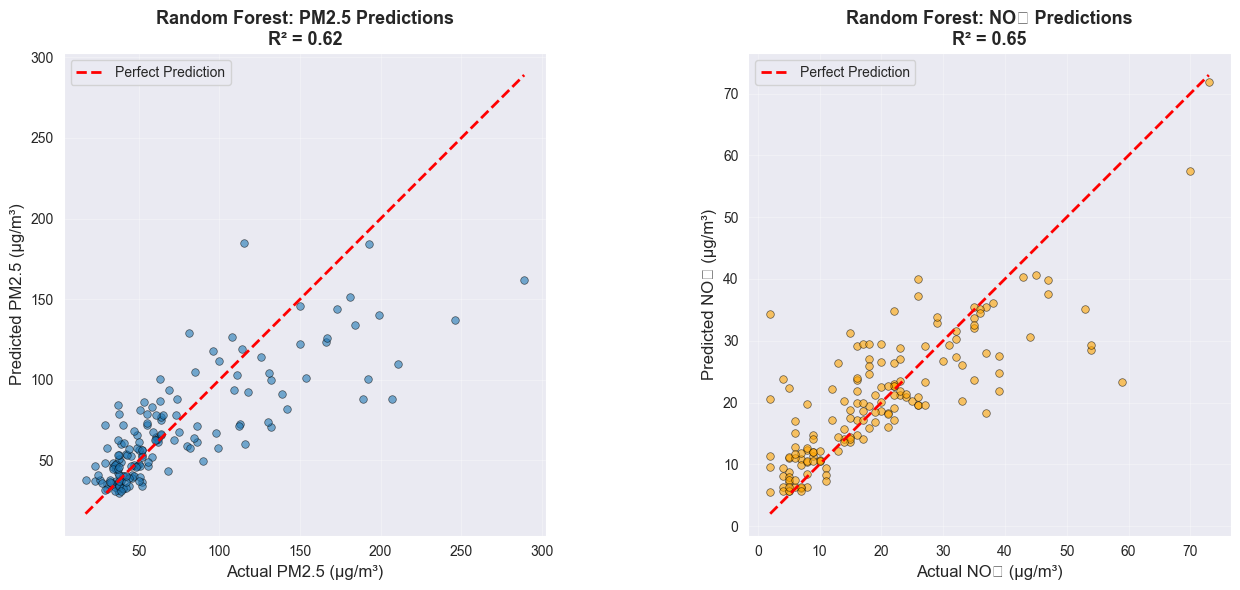

In [39]:
# Predicted vs Actual Plots for Random Forest (Best Model)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Extract actual and predicted values for PM2.5 and NO2
y_actual_pm25 = y_test['pm25'].values
y_pred_pm25 = y_pred_rf[:, 0]
y_actual_no2 = y_test['no2'].values
y_pred_no2 = y_pred_rf[:, 1]

# Calculate R² for display
r2_pm25 = r2_score(y_actual_pm25, y_pred_pm25)
r2_no2 = r2_score(y_actual_no2, y_pred_no2)

# Plot PM2.5: Predicted vs Actual
axes[0].scatter(y_actual_pm25, y_pred_pm25, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
# Add diagonal reference line
min_val_pm25 = min(min(y_actual_pm25), min(y_pred_pm25))
max_val_pm25 = max(max(y_actual_pm25), max(y_pred_pm25))
axes[0].plot([min_val_pm25, max_val_pm25], [min_val_pm25, max_val_pm25], 
              'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual PM2.5 (µg/m³)', fontsize=12)
axes[0].set_ylabel('Predicted PM2.5 (µg/m³)', fontsize=12)
axes[0].set_title(f'Random Forest: PM2.5 Predictions\nR² = {r2_pm25:.2f}', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal', adjustable='box')

# Plot NO2: Predicted vs Actual
axes[1].scatter(y_actual_no2, y_pred_no2, alpha=0.6, s=30, edgecolors='black', linewidth=0.5, color='orange')
# Add diagonal reference line
min_val_no2 = min(min(y_actual_no2), min(y_pred_no2))
max_val_no2 = max(max(y_actual_no2), max(y_pred_no2))
axes[1].plot([min_val_no2, max_val_no2], [min_val_no2, max_val_no2], 
              'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual NO₂ (µg/m³)', fontsize=12)
axes[1].set_ylabel('Predicted NO₂ (µg/m³)', fontsize=12)
axes[1].set_title(f'Random Forest: NO₂ Predictions\nR² = {r2_no2:.2f}', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


**Predicted vs Actual Plots Interpretation**

To visualize model predictions, we plotted the predicted vs. actual values of PM2.5 and NO2 on the test set for the best model (Random Forest):

The predicted PM2.5 values closely track the actual values (points cluster near the diagonal line), though at very high concentrations the model tends to under-predict slightly (common for extreme values). This under-prediction at high concentrations is a typical behavior of regression models, which tend to be conservative when extrapolating to extreme values that are less common in the training data.

For NO2, the scatter is more spread, indicating higher prediction error – many points deviate from the diagonal, reflecting the lower R². Still, there is an upward trend, meaning the model captures some signal (e.g., it can distinguish low vs high NO2 days) but not as sharply as for PM2.5. The wider scatter for NO2 suggests that NO2 levels are more difficult to predict accurately, possibly due to fewer strong predictors or more complex relationships that the model cannot fully capture.

Overall, these plots confirm that the Random Forest is reasonably accurate for PM2.5 across the range of observed values, whereas NO2 predictions have substantial uncertainty (the model often predicts moderate NO2 when actual values were higher, likely due to fewer strong predictors for NO2).


**Conclusion**

Almaty's air pollution from 2020–2024 was frequently at unhealthy levels, driven largely by high particulate matter (PM2.5) concentrations. Through our EDA, we saw that PM2.5 often exceeded 150 µg/m³ (Unhealthy) and was strongly correlated with PM10 and CO, pointing to common source factors (like vehicular emissions, industrial activity, and winter heating). NO2 pollution, while lower in absolute terms, still regularly reached Moderate levels and had some correlation with CO (traffic emissions).

We built and tuned multi-output regression models to predict daily PM2.5 and NO2. The Random Forest model achieved the best performance, capturing about 62% of PM2.5 variance and 65% of NO2 variance on the test set, substantially outperforming a single Decision Tree and even a Linear Regression. The linear model, despite its simplicity, did reasonably well for PM2.5 (thanks to the correlated features) but struggled with NO2, indicating some nonlinearity or interactions were important for NO2 prediction that linear regression couldn't capture. The Decision Tree, without ensemble averaging, was prone to overfitting and provided the least accurate predictions.

From the Random Forest, we learned that PM10 and CO are the most influential features for predicting PM2.5 and NO2, reflecting how days with high dust and combustion byproducts lead to higher fine particulates and nitrogen dioxide. Temporal features (month) also played a role: the model recognizes winter months as a period of elevated pollution (likely due to heating and poor dispersion). This suggests that incorporating seasonal or meteorological data (temperature, wind, etc.) could further improve predictions. The year feature being less important implies that while absolute pollution levels might differ slightly year to year, the patterns the model uses remained fairly consistent across 2020–2024.

In conclusion, our analysis highlights significant air quality issues in Almaty and demonstrates a modeling approach to predict key pollutants. The Random Forest model, leveraging both pollutant interrelations and seasonal indicators, provides a tool for estimating daily PM2.5 and NO2 levels with reasonable accuracy. Further improvements could be made by integrating more features (such as weather conditions or emissions data) and exploring advanced models. Nonetheless, our current models already underscore the known fact: when coarse particle and CO levels are high – especially in winter – residents of Almaty can expect severe fine particulate pollution, which is a serious health concern.
